# CMSC320 - Introduction to Data Science
## Final Tutorial
#### David Martin
---

**Introduction**
>Insert introduction here

**Imports**

The following is an import list of all the Python modules we use for the following tutorial, as well as some global styling settings.

In [192]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime 
import matplotlib.pyplot as plt
import requests
from fuzzywuzzy import process
from bs4 import BeautifulSoup
plt.style.use('seaborn-whitegrid')

---
## Data Collection

The purpose of this section is to begin our analysis by collecting our data. We can find publicly available information about many things on government websites, I went to [Virginia's](https://data.virginia.gov) and found a great dataset of COVID reporting data organized by county. Lets use this as our main data set for this analysis.

Lets start by pulling the data from the dataset [VDH-COVID-19-PublicUseDataset-Cases](https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-Cases/bre9-aqqr) as found on data.virginia.gov, and taking a look at what it contains:

I cloned the dataset and put it in a [GitHub Repository](https://github.com/martindavid1995/Data-Science-Tutorial) in .csv format so that we can have a copy of the data without worrying about it changing on us in the future. We will use [Pandas](https://pandas.pydata.org/pandas-docs/stable/) to read from that .csv and put it into a DataFrame so that we can work with it.

In [193]:
# Pull data on COVID cases across Virginia
covid_data = pd.read_csv("https://raw.githubusercontent.com/martindavid1995/Data-Science-Tutorial/master/Covid_VA.csv")
# Display the first five entries
covid_data.head()

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths
0,03/17/2020,51001,Accomack,Eastern Shore,0,0,0
1,03/17/2020,51003,Albemarle,Thomas Jefferson,0,0,0
2,03/17/2020,51005,Alleghany,Alleghany,0,0,0
3,03/17/2020,51007,Amelia,Piedmont,0,0,0
4,03/17/2020,51009,Amherst,Central Virginia,0,0,0


In looking at this DataFrame, we see our listed columns. Right away we can see that we seem to have reports by county for a number of days which include total cases, hospitalizations, and deaths. Before ending this section, we might want to consider any more information that might be useful for us to get a good understanding of what COVID looks like in Virginia.

Since we will likely at some point be observing our data based on county, it might be helpful for us to get an idea of what counties have the largest and smallest populations. For example looking at death rate: three deaths in a single day in a Virginia county with a population of over 1 million people might mean significantly less than three deaths in a county with a population of 4,000 people. This is something we might want to consider when exploring our data, so we should attempt to find some population information for each county.

A google search of [Virginia Counties by Population](https://www.virginia-demographics.com/counties_by_population) brings us a chart with a value for each of Virginia's 133 counties. While we could sit here and manually enter the populations by hand, we can use python and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to strip the population data off this webpage so that we don't have to do all that manual data entry.

In [194]:
# Use requests to pull data from URL
r = requests.get("https://www.virginia-demographics.com/counties_by_population")
# Use BeautifulSoup to parse the request's HTML
soup = BeautifulSoup(r.content, 'html.parser')
# Find the table object and prettify it
table = soup.find('table').prettify()
# Convert the table into a DataFrame
populations = pd.read_html(str(table))[0]
# Drop the last row because it has data we don't need
populations = populations.drop(index=len(populations.index)-1)
# Display the first five entries
populations.head()

,Rank,County,Population
0,1,Fairfax County,1149439
1,2,Prince William County,466834
2,3,Virginia Beach city/county,450882
3,4,Loudoun County,405312
4,5,Chesterfield County,348500


Perfect! Now we have all of the data we are going to need for this analysis. We have our COVID reporting data, and we have our population sizes for each of our 133 Virginian counties. In the next section, we will begin manipulating these DataFrames so that we are able to have all the information we need to perform our data visualization.

---
## Data Management/Representation

In this section, we will begin modifying our data to contain the information that we need to perform our data visualization. Before we start changing things too much, lets try to get an idea of what our dataset looks like. We might ask to know how many rows of data do we have? What day does the data start and when does it end? Are all of the 133 counties in Virginia represented in our main dataset? Does each county have a report for each day? 

Lets start answering these questions by figuring out how many entries we have in our `covid_data` DataFrame.

In [195]:
print("Total number of columns in the dataset: ",len(covid_data.index))

Total number of columns in the dataset:  103607


So `covid_data` holds quite a bit of information. Over 100,000 rows where each row represents a single counties report on a given day. Next, lets try to see what the dates of the oldest and most recent reports are.

In [196]:
# Prints the minimum and maximum values of a specified column in a DataFrame
def printMinMax(df, column):
    print("Min: ",df[column].min())
    print("Max: ",df[column].max())
    
printMinMax(covid_data, "Report Date")

Min:  01/01/2021
Max:  12/31/2021


If we look at the results of the above cell, we notice our first issue with this dataset. The date range from the days above shows January 1, 2021 as being the earliest recorded date when we can clearly see from the head output in the above cells that we have columns with dates going back into 2020. This must be because there is some inability to compare these date objects in the current dataframe accurately. Lets convert the dates into DateTime objects so we can figure out our actual date range, and manipulate and visualize our data better.

In [197]:
# Split each date string into its components
def dateToDateTime(date: str):
    split = date.split("/")
    month = int(split[0])
    day = int(split[1])
    year = int(split[2])
    # Return a new DateTime object 
    return datetime.date(year, month, day)
    
# Convert each row's Report Date into a readable DateTime
def convertDateTime(df):
    datetimes = []
    for index in df.index:
        date = df.at[index, "Report Date"]
        datetimes.append(dateToDateTime(date))
    
    # Add the new DateTimes to the original DataFrame
    df['DateTime'] = datetimes
    return df

covid_data = convertDateTime(covid_data)
covid_data.head()

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,DateTime
0,03/17/2020,51001,Accomack,Eastern Shore,0,0,0,2020-03-17
1,03/17/2020,51003,Albemarle,Thomas Jefferson,0,0,0,2020-03-17
2,03/17/2020,51005,Alleghany,Alleghany,0,0,0,2020-03-17
3,03/17/2020,51007,Amelia,Piedmont,0,0,0,2020-03-17
4,03/17/2020,51009,Amherst,Central Virginia,0,0,0,2020-03-17


With the new DateTime column added, lets check to see what our actual date range looks like for this dataset.

In [198]:
printMinMax(covid_data, "DateTime")

Min:  2020-03-17
Max:  2022-05-04


Now we have a column with dates that we can actually compare in our data analysis. We can see that our data's report dates span from March 2020 to May 2022. Lets see what counties we have, how many dates are recorded, and see if each county has a report for each date.

In [199]:
# Get a list of the unique counties
counties = covid_data["Locality"].unique()
# Display how many unique counties are in our dataset
print("There are ",len(counties)," unique counties")

# Figure out how many unique dates we have data for
dates = covid_data["DateTime"].unique()
# Display how many unique dates we have
print("There are ",len(dates)," unique dates")

# Get the number of rows containing each unique date in our dataset
date_counts = covid_data["Report Date"].value_counts()
unique_dates = date_counts.unique()
# Display the unique date count values
print("Each date has ",unique_dates[0]," unique entries")

There are  133  unique counties
There are  779  unique dates
Each date has  133  unique entries


This above cell gives us a lot of great information. We now know that we have 133 Virginia counties whose COVID reporting data is in this dataset. We also know that each of the 133 counties has reported COVID data for each of the 779 dates recorded in this table. This is great news for us as it means there shouldn't be any missing data that we need to account for.

Unfortunately, the data provided from the Virginia website only records cumulative data. This means that instead of each county reporting their number of new cases, hospitalizations, and deaths each day, they only report the running total of cases they have in each category since reporting began. While this is important information, it might be useful for us to gather the new reported cases for each date. 

Having a daily report amount give us an easier way to visualize which dates have higher case, hospitalization, and death rates. We can use the difference in values between consecutive days in order to determine how many new cases are reported each day.

While we're at it, we should separate our DataFrames by county, since we will be looking at individual counties in our data analysis. Lets go ahead and do this manipulation.

In [200]:
# Takes a dataframe for a specific county and adds a column that shows the number of new cases reported for each report date
def genColumnDifference(df, column):
    offsets = []
    # For each row in the dataframe
    for index in df.index:
        if index == 0:
            offsets.append(0)
        else:
            # Compute the difference in the specified column of the current report date minus the previous report date
            offsets.append(df.at[index, column] - df.at[index-1, column])
    # Append this column to the dataframe
    df[column+" Per Day"] = offsets
    return df

county_frames = []
# For each county 
for county in counties:
    # Construct a new dataframe consisting only of rows corresponding to this county
    county_frame = covid_data.loc[covid_data["Locality"] == county]
    # Reset the indices
    county_frame = county_frame.reset_index(drop=True)
    # Get the column differences for Total Cases, Hospitalizations, and Deaths
    county_frame = genColumnDifference(county_frame, "Total Cases")
    county_frame = genColumnDifference(county_frame, "Hospitalizations")
    county_frame = genColumnDifference(county_frame, "Deaths")
    # Add it to our list of counties
    county_frames.append(county_frame)

county_frames[12].head()

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,DateTime,Total Cases Per Day,Hospitalizations Per Day,Deaths Per Day
0,03/17/2020,51025,Brunswick,Southside,0,0,0,2020-03-17,0,0,0
1,03/18/2020,51025,Brunswick,Southside,0,0,0,2020-03-18,0,0,0
2,03/19/2020,51025,Brunswick,Southside,0,0,0,2020-03-19,0,0,0
3,03/20/2020,51025,Brunswick,Southside,0,0,0,2020-03-20,0,0,0
4,03/21/2020,51025,Brunswick,Southside,0,0,0,2020-03-21,0,0,0


Now that we have the daily counts for each metric divided into separate DataFrames for each of our counties, we need to make sure we can easily pull the population counts for each county to help in our analysis. Ideally, we will define a function where we can pass in the `Locality` value from a row in the `covid_data` frame, and get the resulting population for that county out of our `populations` frame. 

Unfortunately, counties are do not have the same naming conventions between the two DataFrames. For example, if we are looking for the population for **"Fairfax"** as written in `covid_data`, its corresponding value is titled **"Fairfax County"** in the `populations` DataFrame. We need to modify these values so that we can use the same lookup key to easily access this information in the future. 

We can use this by using the Python library [FuzzyWuzzy](https://pypi.org/project/fuzzywuzzy/) to compute [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) between pairs of strings. We can then use these measures to match our county names in one frame to line them up with one another. We will find the best matching strings for these two columns and change the value in the `County` column in the `populations` frame to match its respective county in the `Locality` column in the `covid_data` frame.

In [201]:
# Get all of the counties from populations DataFrame in a list
pop_counties = populations['County'].unique()

# For each unique county name in our covid_data main DataFrame
for county in counties:
    # Use FuzzyWuzzy to find the value in the 'County' column of populations most similar to the value in the 'Locality' column in covid_data
    proc = process.extract(county, pop_counties, limit=1)
    # The match variable represents the matching county name in populations
    (match, score) = proc[0]
    # Get the index of that value in our populations frame
    index = populations.index[populations['County'] == match]
    # Rename the value in our populations frame so that it is identical to its respective county in in covid_data
    populations.at[index,'County'] = county
    
populations.head()

,Rank,County,Population
0,1,Fairfax,1149439
1,2,Prince William,466834
2,3,Virginia Beach,450882
3,4,Loudoun,405312
4,5,Chesterfield,348500


Lets quickly define a function to pull the population of any `Locality` from our main `covid_data` database. While we're at it, lets run a quick check to make sure we can pull a population value for each entry in our `covid_data` DataFrame. 

In [202]:
def getPopulation(county: str):
    return populations.loc[populations['County'] == county]['Population'].values[0]

In [203]:
# There is one county that doesn't match up in our populations DataFrame
for index,row in populations.iterrows():
    # Find the bad county and manually fix it
    if populations.at[index, 'County'] == 'Charlotte County':
        populations.at[index, 'County'] = 'Charlotte'

# Get the unique county names in each frame
population_counties = populations['County'].unique()
covid_data_counties = covid_data['Locality'].unique()

# Check for any that don't match
mismatched_values = 0
for ct in population_counties:
    if ct not in covid_data_counties:
        mismatched_values += 1

print("Found ",mismatched_values," mismatched values between our two DataFrames")

Found  0  mismatched values between our two DataFrames


Excellent! Now we can easily look up a counties population by just plugging in the `Locality` value in `covid_data` for that county.

This concludes the **Data Management** section of the tutorial. Our data is now set up in a way where we can visualize it and perform some analysis. In the next section, we will begin visualizing and analyzing the COVID data.

---
## Exploratory Data Analysis

In this section, we will being visualizing and interpreting the COVID data for the state of Virginia. We will be using `Matplotlib` as our main visualization tool. 


Lets start by looking COVID data by simply plotting our `Total Cases` over time from our original dataset. We can use `Matplotlib` to achieve this rather easily.

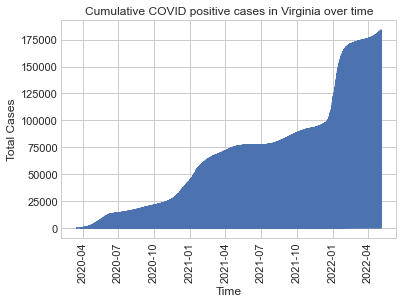

In [204]:
# Create figure and axes
fig = plt.figure()
ax = plt.axes()

# Plot with x axis as time and y axis as total cases
ax.plot(covid_data["DateTime"], covid_data["Total Cases"])

# Set labels and title
plt.xlabel("Time")
plt.ylabel("Total Cases")
plt.title("Cumulative COVID positive cases in Virginia over time")

# Rotate ticks
plt.xticks(rotation=90)
plt.show()

As expected, the total number COVID cases in Virginia goes up over time. This is pretty intuitive as there is no way for the total cases to go down because it is a cumulative measure. From this chart we can gather some information about COVID contraction rates. We see two sections with steep slopes - January 2020 and January 2021 show massive relative spikes in total cases state-wide. This comes as no surprise, as the winter months involved cold/flu season as well as lots of family gatherings which might have increase the rate of spread.

In my opinion, plotting cases like this is rather misleading. To me this chart make it look like COVID is getting way worse over time, whereas in reality the actual number of new cases is not increasing. It will be a lot more representative to see what the cases per day looks like if we want a better understanding of when COVID is at its worst in Virginia. Lets pick out a few counties to 